In [2]:
import numpy as np
import matplotlib.pyplot as plt
from celluloid import Camera
import networkx as nx
import time

import tensorflow as tf
from tensorflow import keras

%matplotlib notebook

In [3]:
class Distributed_System():
    def __init__(self, N, L):
        np.random.seed(41)
        self.N = N
        self.L = L
        
        # Variables: x , y (positions of agents in plan)
        self.x = np.random.rand(N)*L           # Initialize xᵢ
        self.y = np.random.rand(N)*L           # Initialize yᵢ
        self.x[0] = 0; self.x[1] = 1; self.x[2] = 0; 
        self.y[0] = 0; self.y[1] = 0; self.y[2] = 1; 
        
        self.r = np.ones(N)                    # Wave sending radius
        self.A = np.zeros((N,N))               # Adjacency Matrix
        self.k = np.zeros(N)                   # Degree of a vertex
        for i in range(N):
            for j in range(i+1,N):
                if ( (self.x[i]-self.x[j])**2 + (self.y[i]-self.y[j])**2 )**0.5 < self.r[i]:
                    self.A[i][j] = self.A[j][i] = 1
                    self.k[i]   += self.A[i][j]
                    self.k[j]   += self.A[i][j]
                    
        
        
    def step(self, r):
        Hamilton_t0 = np.zeros(self.N)
        Hamilton_t1 = np.zeros(self.N)
        for i in range(self.N):
            Hamilton_t0[i], e = self.Hamiltonian(i)    ###
        
        self.A = np.zeros((N,N))
        self.r = r
        self.k = np.zeros(N)
        mean_r_ij = np.zeros((N))
        
        for i in range(self.N):
            for j in range(i+1, self.N):
                distance = ( (self.x[i]-self.x[j])**2 + (self.y[i]-self.y[j])**2 )**0.5
                if distance < self.r[i] and distance < self.r[j]:
                    self.A[i][j] = self.A[j][i] = 1;
                    self.k[i]   += self.A[i][j]
                    self.k[j]   += self.A[i][j]

                    mean_r_ij[i] += distance
                    mean_r_ij[j] += distance
        
        for i in range(self.N):
            Hamilton_t1[i], e = self.Hamiltonian(i)    ###
        reward = Hamilton_t0 - Hamilton_t1
        return ([ self.k, self.r, mean_r_ij/(self.k+1e-10) ], reward)
        
        
    def Hamiltonian(self, i):
        alfa_1 = -0.5
        alfa_2 = +0.1
        alfa_3 = +0.2
        alfa_4 = -0.5
        
        fourth = np.zeros(self.N)
        for j in range(self.N):
            if i != j:
                fourth[i] += (self.A[i][j] / (( (self.x[i]-self.x[j])**2 + (self.y[i]-self.y[j])**2 )**0.5 ))
            
        H = alfa_1*self.k[i]**2 + alfa_2*self.k[i]**3 + alfa_3*self.r[i]**2 + alfa_4*fourth[i]
        return H, fourth[i]                ###
    
    

    def Plot(self, episode):                ###
        options = { 'node_size': 60, 'width': 0.3 }
        
        G = nx.from_numpy_array(self.A)
        for i in range(self.N):
            G.add_node(i, pos=(self.x[i], self.y[i]))
        pos = nx.get_node_attributes(G,'pos')
        
        nx.draw_networkx(G, pos, with_labels=False, **options)
        
        plt.text(self.L-0.15*self.L, self.L+0.3, f'Episode {episode}', fontname='Comic Sans MS', fontsize=12)        ###
        plt.tick_params(left=True, bottom=True, labelleft=True, labelbottom=True)
        plt.xlim(-0.1, self.L+0.1); plt.ylim(-0.1, self.L+0.1);
        plt.grid(alpha = 0.3);
        camera.snap()
#         plt.show()

In [4]:
N = 3                      # Number of agents
L = 2                       # The length of the simulation box

env = Distributed_System(N,L)
# env.Plot()

In [15]:
tf.random.set_seed(41)
np.random.seed(41)

input_shape = [3]              # == env.observation_space.shape
n_outputs = 1                  # == env.action_space.n

model = []
for i in range(N):
    model.append(keras.models.Sequential([
        keras.layers.Dense(10, activation="relu", input_shape=input_shape),
        keras.layers.Dense(10, activation="relu"),
        keras.layers.Dense(n_outputs, activation="sigmoid")
    ]))

In [6]:
from collections import deque
replay_memory = []
for i in range(N):
    replay_memory.append(deque(maxlen=800))

def play_one_step(env, state, epsilon=0.):
    action = np.zeros(N)

    for i in range(N):
        if np.random.rand() < epsilon:
            action[i] = np.random.rand(n_outputs)*L
        else:
            action[i] = model[i].predict(np.reshape(state[i], (3)).reshape(1, -1), verbose=0)[0]*L
    
    next_state, reward = env.step(action)
    next_state = [[next_state[j][i] for j in range(3)] for i in range(N)]
    
    for i in range(N):
        replay_memory[i].append((state[i], action[i], reward[i], next_state[i]))
    return next_state, reward

In [16]:
batch_size = 32
discount_rate = 0.95
optimizer = keras.optimizers.legacy.Adam(learning_rate=1e-2)
loss_fn   = keras.losses.mean_squared_error

def training_step(i, batch_size):
    indices = np.random.randint(len(replay_memory[i]), size=batch_size)   # 32ta random number between[0 - len(replay)]
    batch   = [replay_memory[i][index] for index in indices]              # number in replay_memory[indices]
    
    states, actions, rewards, next_states = [                             # from replay_memory read these and save in...
        np.array([experience[field_index] for experience in batch])
        for field_index in range(4)]
    
    
    next_Q_values   = model[i].predict(next_states, verbose=0)*L          # 32 predict of 2 actions
#     print(f"\n  Next Q {i}: {next_Q_values[1]} \t ")
    next_Q_values   = np.squeeze(next_Q_values)                           # reshape to (32,) beacuse of rewards.shape
    target_Q_values = -rewards + discount_rate*next_Q_values               # Equation 18-5. Q-Learning algorithm
#     print(f"  Reward {i}: {rewards[1]} \n  Target Q {i}: {target_Q_values[1]} \t ")
    target_Q_values = target_Q_values.reshape(-1, 1)                      # reshape to (32,1) beacuse of Q_values.shape
    
#     if i==1:
#         print(f"\n  Next Q Values {i}: \n{next_Q_values.max()}")
#         print(f"\n  Rewards {i}: \n{rewards}")
#         print(f"\n  Target Q Values {i}: \n{target_Q_values}")
#         print(f"\n  Trainable Variables {i}: \n{model[1].trainable_variables}")
        
    
    
    with tf.GradientTape() as tape:
        Q_values = model[i](states)*L
#         print(f"  Q values {i}: {Q_values[1]} \t ")
        loss = tf.reduce_mean(loss_fn(target_Q_values, Q_values))
#         if i==1:
#         print(f"  LOOS {i}: {loss}")
    grads = tape.gradient(loss, model[i].trainable_variables)
    optimizer.apply_gradients(zip(grads, model[i].trainable_variables))

<IPython.core.display.Javascript object>


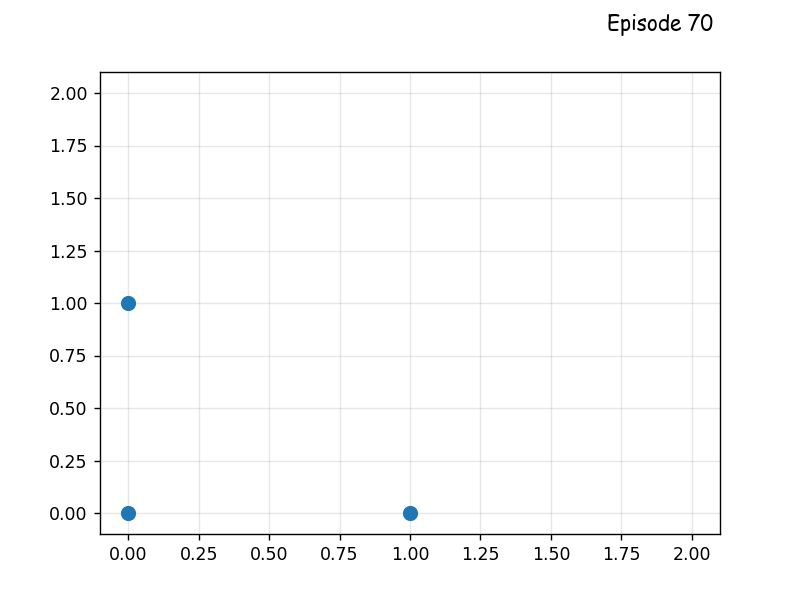

Episode: 3999, eps: 0.010, Time One Step: 0.273
Total Time: 1624.0997052192688


In [17]:
state, reward = env.step(np.ones(N))
state = [[state[j][i] for j in range(3)] for i in range(N)]

f = open("log.txt", "w")
f.write(f"episode \t epsilon \t ")
for i in range(N): f.write(f"r{i} \t ")
for i in range(N): f.write(f"k{i} \t ")
for i in range(N): f.write(f"k{i}**2 \t ")
for i in range(N): f.write(f"k{i}**3 \t ")
for i in range(N): f.write(f"r{i}**2 \t ")
for i in range(N): f.write(f"fourth{i} \t ")
for i in range(N): f.write(f"H{i} \t ")
for i in range(N): f.write(f"reward{i} \t ")
f.write(f"Hamilton \t Time(one_step) \t Time(training) \n")
    

camera = Camera(plt.figure())   
start_total = time.time()
for episode in range(4000):
    Hamilton = 0
    epsilon = max(1 - (episode)/500, 0.01)            # first is more random and than use greedy
    
    ti_onestep = time.time()                        ### not shown
    state, reward = play_one_step(env, state, epsilon)
    tf_onestep = time.time()                        ### not shown
    
    ti_train = time.time()                          ### not shown
    if episode > 200:
        for i in range(N):
            training_step(i, batch_size)
    tf_train = time.time()                          ### not shown
    
    if episode%10 == 0:
        env.Plot(episode)
        
        
    for i in range(N):
        Hamilton += env.Hamiltonian(i)[0]
      
    
    f.write(f"{episode} \t {epsilon} \t ")
    for i in range(N): f.write(f"{env.r[i]} \t ")
    for i in range(N): f.write(f"{env.k[i]} \t ")
    for i in range(N): f.write(f"{env.k[i]**2} \t ")
    for i in range(N): f.write(f"{env.k[i]**3} \t ")
    for i in range(N): f.write(f"{env.r[i]**2} \t ")
    for i in range(N): f.write(f"{env.Hamiltonian(i)[1]} \t ")
    for i in range(N): f.write(f"{env.Hamiltonian(i)[0]} \t ")
    for i in range(N): f.write(f"{reward[i]} \t ")
    f.write(f"{Hamilton} \t {tf_onestep-ti_onestep} \t {tf_train-ti_train} \n")
    
    print("\rEpisode: {}, eps: {:.3f}, Time One Step: {:.3f}".format(episode, epsilon, tf_onestep-ti_onestep), end="")
    
    
print(f"\nTotal Time: {time.time() - start_total}")

anim = camera.animate(interval= 100, repeat=True, repeat_delay= 500, blit=True)
anim.save('animation_.gif')
f.close()

In [ ]:
indices = np.random.randint(len(replay_memory[1]), size=32)   # 32ta random number between[0 - len(replay)]
batch   = [replay_memory[1][index] for index in indices]              # number in replay_memory[indices]

sta, act, rew, next_sta = [                             # from replay_memory read these and save in...
    np.array([experience[field_index] for experience in batch])
    for field_index in range(4)]


next_Q_values   = model[1].predict(next_sta, verbose=0)            # 32 predict of 2 actions
# next_Q_values   = np.squeeze(next_Q_values)                           # reshape to (32,) beacuse of rewards.shape

print(f"Next Q Values: \n{next_Q_values.shape}")
print(tf.clip_by_value(next_Q_values, clip_value_min=0, clip_value_max=10).numpy().shape)

next_Q_values   = np.squeeze(next_Q_values)
target_Q_values = (rew + discount_rate*next_Q_values)             # Equation 18-5. Q-Learning algorithm
target_Q_values = target_Q_values.reshape(-1, 1)                      # reshape to (32,1) beacuse of Q_values.shape

print()
print(f"\nTarget Q Values: \n{target_Q_values.shape}")
print(tf.clip_by_value(target_Q_values, clip_value_min=0, clip_value_max=10).numpy().shape)

Q_values = model[1](sta)

print(f"\nQ Values: \n{Q_values.shape}")
print(tf.clip_by_value(Q_values, clip_value_min=0, clip_value_max=10).numpy().shape)
loss = tf.reduce_mean(loss_fn(target_Q_values, Q_values))
if i==1:
    print(f"\n  LOOS: {loss}")

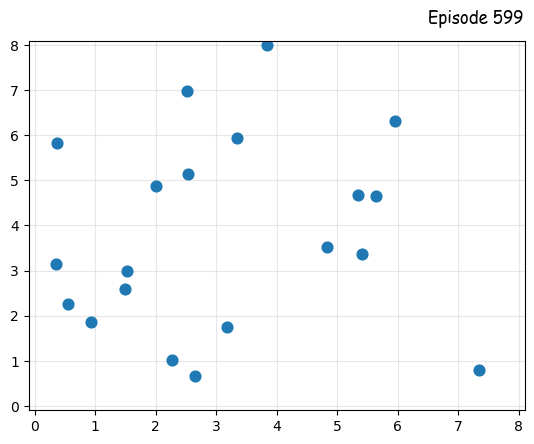

In [11]:
%matplotlib inline

options = { 'node_size': 60, 'width': 0.3 }
        
G = nx.from_numpy_array(env.A)
for i in range(N):
    G.add_node(i, pos=(env.x[i], env.y[i]))
pos = nx.get_node_attributes(G,'pos')

nx.draw_networkx(G, pos, with_labels=False, **options)

plt.text(L-1.5, L+0.5, f'Episode {episode}', fontname='Comic Sans MS', fontsize=12)        ###
plt.tick_params(left=True, bottom=True, labelleft=True, labelbottom=True)
plt.xlim(-0.1, L+0.1); plt.ylim(-0.1, L+0.1);
plt.grid(alpha = 0.3);
plt.show()